In [10]:
import os
from fastai.vision.all import *
from pathlib import Path

In [11]:
# Path to your dataset
trn_path = Path(r"BioID-FaceDatabase-V1.2/")  # Replace with your BioID dataset folder path

(384, 286)


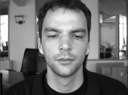

In [12]:
files = get_image_files(trn_path)
img = PILImage.create(files[0])
print(img.size)
img.to_thumb(128)

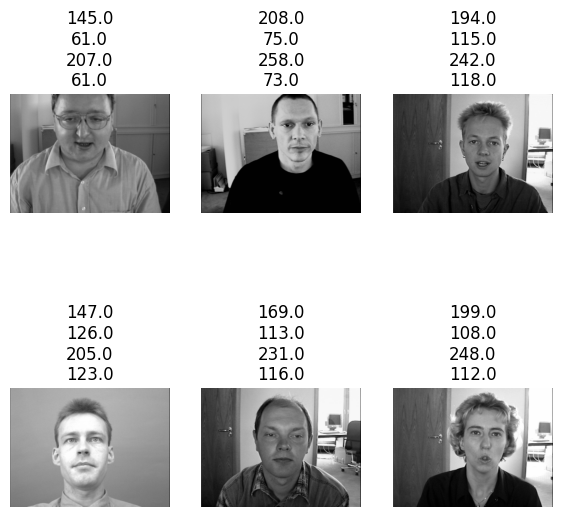

In [13]:
# Function to parse eye position labels from `.eye` files
def parse_eye_positions(eye_file):
    with open(eye_file, 'r') as f:
        lines = f.readlines()
        left_eye_x, left_eye_y, right_eye_x, right_eye_y = map(float, lines[1].split())
        return left_eye_x, left_eye_y, right_eye_x, right_eye_y

# Functions to extract each target, swapped to match image's perspective
def get_left_eye_x(image_path):
    eye_file = image_path.with_suffix('.eye')
    return parse_eye_positions(eye_file)[2]  # Right eye X (person's left eye)

def get_left_eye_y(image_path):
    eye_file = image_path.with_suffix('.eye')
    return parse_eye_positions(eye_file)[3]  # Right eye Y (person's left eye)

def get_right_eye_x(image_path):
    eye_file = image_path.with_suffix('.eye')
    return parse_eye_positions(eye_file)[0]  # Left eye X (person's right eye)

def get_right_eye_y(image_path):
    eye_file = image_path.with_suffix('.eye')
    return parse_eye_positions(eye_file)[1]  # Left eye Y (person's right eye)

# Define the DataBlock
dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock, RegressionBlock, RegressionBlock, RegressionBlock),
    n_inp=1,
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=[get_left_eye_x, get_left_eye_y, get_right_eye_x, get_right_eye_y],
)

#Create the DataLoaders
dls = dblock.dataloaders(trn_path, bs=20)  # Adjust batch size as needed

# Visualize a batch
dls.show_batch(max_n=6, figsize=(7, 7))

In [14]:
# Loss Functions
def MSELossFlat(input, target):
    return ((input - target)**2).mean()

def net_Loss(input_from_model, leftEyeX, leftEyeY, rightEyeX, rightEyeY):
    leftEyeX /= 384  # Normalize width
    rightEyeX /= 384
    leftEyeY /= 286  # Normalize height
    rightEyeY /= 286
    return (
        MSELossFlat(input_from_model[:, 0], leftEyeX) +
        MSELossFlat(input_from_model[:, 1], leftEyeY) +
        MSELossFlat(input_from_model[:, 2], rightEyeX) +
        MSELossFlat(input_from_model[:, 3], rightEyeY)
    )

# architecture = 'convnext_small_in22k' #Best Validation MSE : 5509446.000000 (10 epochs) (lr = 0.1)
architecture = 'convnext_tiny' #Best Validation MSE : 327073 (10 epochs) (lr = 0.2)
# architecture = 'regnety_006' #Best Validation MSE :  ( epochs) (lr = )

learn = vision_learner(dls, architecture, loss_func=net_Loss, n_out=4).to_fp16()

c:\Users\Geetansh\Desktop\BioID\Mlvenv\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Geetansh\.cache\huggingface\hub\models--timm--convnext_tiny.in12k_ft_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


### Try1

#### Find learning rate

c:\Users\Geetansh\Desktop\BioID\Mlvenv\Lib\site-packages\fastai\learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **

Learning rate at valley: 0.0014454397605732083
Learning rate at steepest point: 0.0063095735386013985


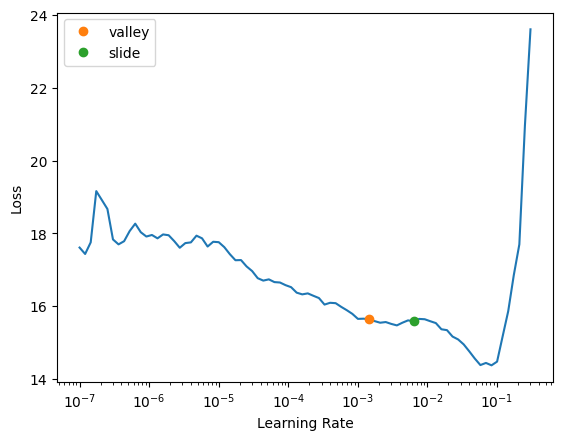

In [15]:
lr_min, lr_steep = learn.lr_find(suggest_funcs=(valley, slide)) 
print(f"Learning rate at valley: {lr_min}") 
print(f"Learning rate at steepest point: {lr_steep}")

#### Train

epoch,train_loss,valid_loss,time
0,13.497436,4.552320,02:27


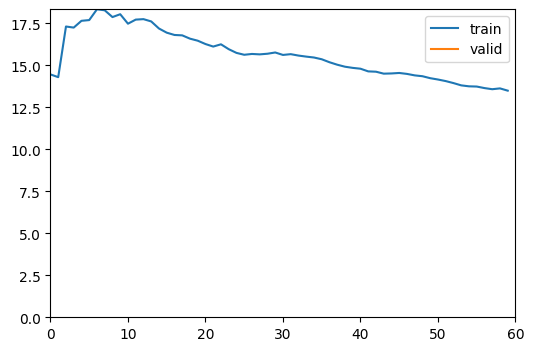

epoch,train_loss,valid_loss,time
0,10.056679,1.776304,03:55
1,8.863066,1.358586,04:04
2,8.589732,1.242199,03:59
3,8.237212,1.206133,03:57
4,7.450939,1.022318,03:55
5,7.248240,0.848742,04:00
6,7.027908,0.821202,04:10
7,6.370689,0.774190,04:03
8,6.247385,0.820059,04:02
9,5.897345,0.645738,03:57


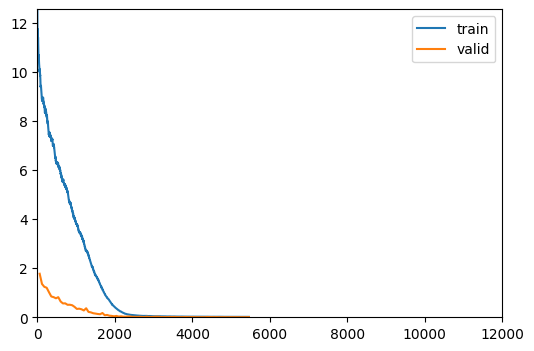

No improvement since epoch 81: early stopping


In [16]:
from fastai.callback.tracker import EarlyStoppingCallback

learn.fine_tune(200, 0.001, cbs=[
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor='valid_loss', comp=np.less, patience=10, min_delta=1e-5)
])

# Export Model, Make inference

In [17]:
learn.save('finalModel4_saved')

Path('models/finalModel4_saved.pth')

In [22]:
# Path to the image file
img_path = r"./BioID-FaceDatabase-V1.2/BioID_0000.pgm"

dl = learn.dls.test_dl([img_path])  # Create a DataLoader with the same transformations
predictions = learn.get_preds(dl=dl)
print(predictions)

(tensor([[0.4219, 0.3838, 0.6128, 0.3796]]), None)


In [23]:
# Adjust predictions to match the image's perspective
# Assuming predictions[0] contains the prediction tensor
pred_tensor = predictions[0]

# Convert the list to a tensor for scaling
multiplier_tensor = torch.tensor([384, 286, 384, 286], device=pred_tensor.device)

# Perform element-wise multiplication to scale back to original dimensions
scaled_predictions = pred_tensor * multiplier_tensor

print("Adjusted predictions (image perspective):", scaled_predictions)


Adjusted predictions (image perspective): tensor([[162.0000, 109.7637, 235.3125, 108.5767]])


#### Load model : Not working

In [25]:
newLearn = save("./finalModel_export")

NameError: name 'save' is not defined

In [ ]:
predictions = newLearn.predict(img_path)
predictions
# pred_tensor = predictions[0]

# # Convert the list to a tensor for scaling
# multiplier_tensor = torch.tensor([384, 286, 384, 286], device=pred_tensor.device)

# # Perform element-wise multiplication to scale back to original dimensions
# scaled_predictions = pred_tensor * multiplier_tensor

# print("Adjusted predictions (image perspective):", scaled_predictions)

# Check GPU 

In [1]:
import torch
print(torch.cuda.is_available())

torch.cuda.empty_cache()

True
